In [ ]:
import sys
import os
build_path = os.path.join(os.getcwd(), "..", "build")
!cmake -B {build_path} -DPYTHON_EXECUTABLE={sys.executable} -Wno-dev -DCMAKE_BUILD_TYPE=Release ..
!cmake --build {build_path}

In [3]:
os.chdir(build_path)
import pypumila
# to reload pypumila, restart python kernel.
# importlib.reload(pypumila) <- does not work

import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

In [5]:
def learn(hidden, gamma, it = 100000, model = None):
    print(f"hidden = {int(hidden)}")
    print(f"gamma = {gamma}")
    if model is None:
        model = pypumila.Pumila13.make_shared(int(hidden), gamma)
    op_models = [
        lambda: pypumila.Pumila3.make_shared(""),
        lambda: pypumila.Pumila8s.make_shared("pumila8s_3162"),
        lambda: pypumila.Pumila11.make_shared("pumila11_300_0.9_100000"),
    ]
    reward = []
    score = []
    # ih = []
    sim = pypumila.GameSim()
    rnd_p = random.random()
    op_model = random.choice(op_models)()
    op_sim = pypumila.GameSim(op_model)
    sim.set_opponent_sim(op_sim)
    with tqdm(total=it) as pbar:
        while pbar.n < it:
            # for e in range(max_step):
            pbar.update()
            field_before = sim.field2_copy()
            op_field_before = op_sim.field2_copy()
            a = model.get_action_rnd(field_before, op_field_before, rnd_p)
            sim.put(pypumila.actions[a])
            op_sim.step()
            while not sim.is_free_phase():
                sim.step()
                op_sim.step()
            field_after = sim.field2_copy()
            op_field_after = op_sim.field2_copy()
            model.learn_step(field_before, a, op_field_before, field_after, op_field_after)
            reward.append(model.calc_reward(field_after, op_field_after))
            score.append(field_after.total_score())
            if sim.is_over:
                sim = pypumila.GameSim()
                rnd_p = random.random()
                sim.set_opponent_sim(op_sim)
            if op_sim.is_over:
                op_sim.stop_action()
                op_model = random.choice(op_models)()
                op_sim = pypumila.GameSim(op_model)
                sim.set_opponent_sim(op_sim)
    model.save_file(f"pumila13_{hidden}_{gamma}_{it}_3-8-11")
    return [model, reward, score]

In [6]:
models = []
rewards = []
scores = []
labels = [1000, 3000] #[1000, 3000, 10000]
for hidden in labels:
    model, reward, score = learn(hidden, 0.9, 2000000)
    models.append(model)
    rewards.append(reward)
    scores.append(score)

hidden = 1000
gamma = 0.9


  0%|          | 0/2000000 [00:00<?, ?it/s]

hidden = 3000
gamma = 0.9


  0%|          | 0/2000000 [00:00<?, ?it/s]

In [5]:
# for i, gamma in enumerate([0.5, 0.75, 0.9, 0.99]):
#     model, reward, score = learn(300, gamma, 100000, 100, models[i])
#     models[i] = model
#     rewards[i] += reward
#     scores[i] += score

In [7]:
[len(m.diff_history) for m in models]

[2000000, 2000000]

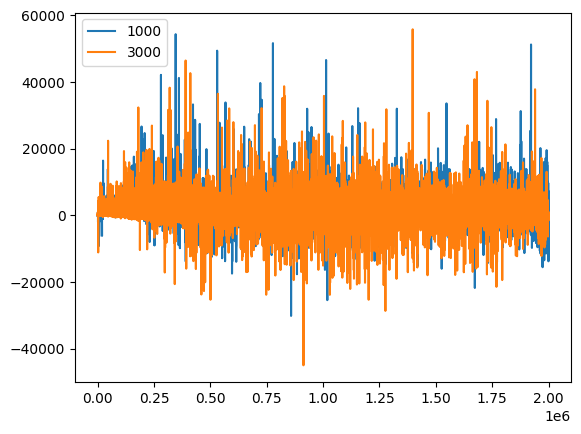

In [8]:
l = min(len(m.diff_history) for m in models)
plt.plot(np.array([m.diff_history[:l] for m in models]).T, label=labels)
plt.legend()

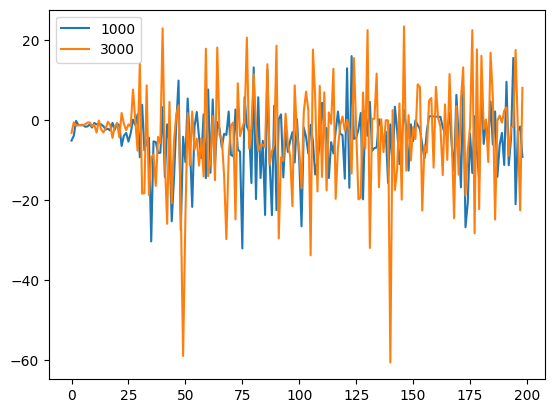

In [9]:
ar = np.array([m.diff_history[:l] for m in models])
plt.plot(np.array([[np.average(ar[j, i:i+10000]) for i in range(0, l-10000, 10000)] for j in range(len(models))]).T, label=labels)
plt.legend()

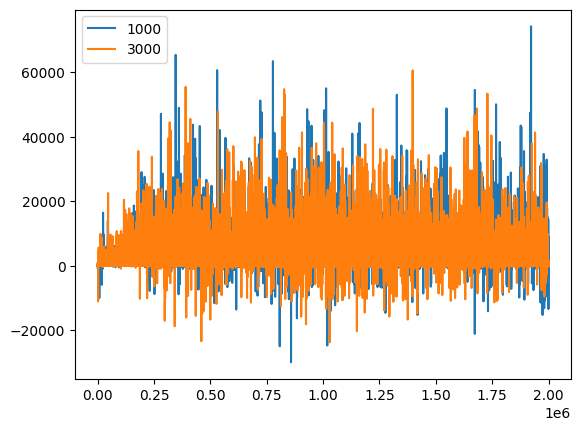

In [10]:
plt.plot(np.array(rewards)[:, :, 0].T, label=labels)
plt.legend()

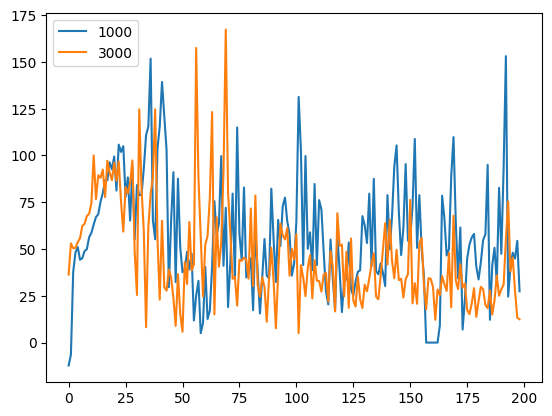

In [11]:
ar = np.array(rewards)[:, :, 0]
plt.plot(
    np.array([[np.average(ar[j, i:i+10000]) for i in range(0, len(rewards[j])-10000, 10000)] for j in range(len(rewards))]).T,
    label=labels
)
plt.legend()

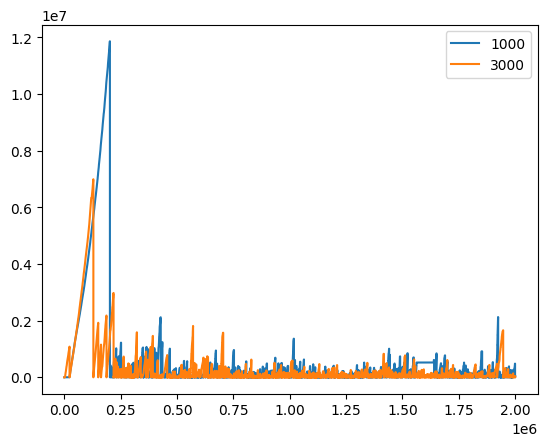

In [12]:
plt.plot(np.array(scores).T, label=labels)
plt.legend()

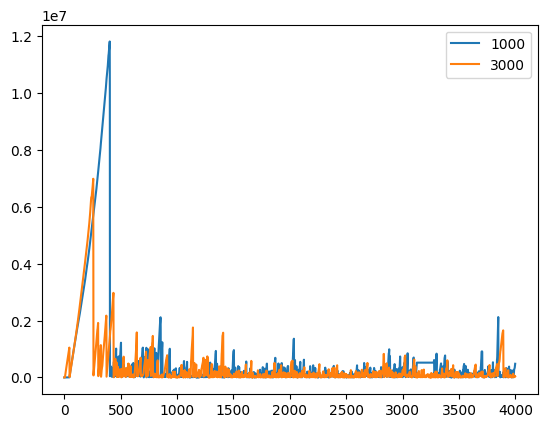

In [13]:
ar = np.array(scores)
plt.plot(
    np.array([[np.average(ar[j, i:i+500]) for i in range(0, len(scores[j])-500, 500)] for j in range(len(scores))]).T,
    label=labels
)
plt.legend()

(0.0, 1000000.0)

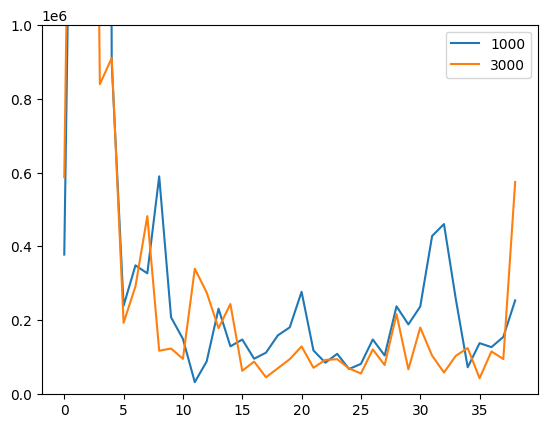

In [14]:
ar = np.array(scores)
plt.plot(
    np.array([[np.average(ar[j, i:i+50000]) for i in range(0, len(scores[j])-50000, 50000)] for j in range(len(scores))]).T,
    label=labels
)
plt.legend()
plt.ylim(0, 1000000)

In [3]:
# models = []
# labels = [1000, 3000, 10000]
# for hidden in labels:
#     gamma = 0.9
#     it = 2000000
#     models.append(pypumila.Pumila13.make_shared(f"pumila13_{hidden}_{gamma}_{it}"))

In [19]:
sim = pypumila.GameSim()
op_sim = pypumila.GameSim(pypumila.Pumila11.make_shared("pumila11_300_0.9_100000"))
sim.set_opponent_sim(op_sim)
win = pypumila.Window([sim, op_sim])
model = models[0]
# model = pypumila.Pumila11.make_shared(1, 1)
# model.load_file("pumila11_300_0.5_10000")

In [20]:
def get_in(f, op_f):
    in_my = 1+6*13*5+6*13*4+20
    in_nodes = model.get_in_nodes(f, op_f).in_nodes
    in_opgarbage = in_nodes[0, in_my: in_my+12]
    in_opheight = in_nodes[0, in_my+12: in_my+18]
    in_opfchain = in_nodes[0, in_my+18: in_my+38]
    in_opchain = in_nodes[0, in_my+38: in_my+58]
    return (in_opgarbage, in_opheight, in_opfchain, in_opchain)

In [ ]:
prev_r = ""
prev_n = ""
# con = []
while True:
    while not sim.is_free_phase():
        win.step(True)
        # if sim.current_chain and sim.current_chain.connections != con:
        #     print(sim.current_chain.connections)
        #     con = sim.current_chain.connections
    f = sim.field2_copy()
    op_f = op_sim.field2_copy()
    in_info = get_in(f, op_f)
    # n = f"in_opgarbage = {in_info[0]}\n"
    # n += f"in_opheight = {in_info[1]}\n"
    n = f"in_opfchain = {in_info[2]}\n"
    n += f"in_opchain = {in_info[3]}\n"
    if prev_n != n:
        prev_n = n
        print(n)
    r = f"reward: {model.calc_reward(f, op_f)}"
    if prev_r != r:
        prev_r = r
        print(r)
    a = model.get_action(sim)
    print(f"coeff: {model.action_coeff()}")
    sim.soft_put(pypumila.actions[a])
    while sim.is_free_phase():
        win.step(True)

In [ ]:
model.get_in_nodes(f).in_nodes[:, -20:]

In [18]:
win.quit()